In [4]:
!pip install tashaphyne
!pip install emoji

  Using cached Tashaphyne-0.3.6-py3-none-any.whl (251 kB)


In [5]:
import pandas as pd 
import numpy as np
import nltk
import regex as re
import emoji
import string
from tashaphyne.stemming import ArabicLightStemmer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report, accuracy_score, f1_score
import random
import seaborn as sns
import matplotlib.pyplot as plt

import warnings as wr
wr.filterwarnings("ignore")

# Data Preprocessing

In [6]:
def Cleaning(copy_data):
    copy_data['class']=copy_data['class'].replace({'pos':1,'neg':0})
    copy_data.drop(copy_data.columns[copy_data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True) #remove unnamed columns . 
    copy_data['sentenses_len'] = 0
    copy_data['puretext'] = 0 
    copy_data['#english_words'] = 0 
    copy_data['#hashtags'] = 0 
    copy_data['#mentioning'] = 0 
    copy_data['#hyperlinks'] = 0 
    copy_data['#numbers'] = 0
    copy_data['#emojis']=0
    
    return copy_data

In [7]:
def tokenization(x,idx): # take data copy
        tokens = nltk.word_tokenize(x['text'][idx])
        return tokens
def segmentation(x,idx): # take data copy 
    s_tokens = nltk.data.load('tokenizers/punkt/english.pickle')
    sentens = s_tokens.tokenize(x['text'][idx])
    x['sentenses_len'][idx] = len(sentens) #save length of sentenses in the csv "data set "  file  
    # print(len(sentens))    
def drop_stop_words(x): #take data copy
    arb_stop_words = set(nltk.corpus.stopwords.words("arabic"))
    tokensOfpureTextWithoutstop=[token for token in x if token not in arb_stop_words]
    return tokensOfpureTextWithoutstop
def stemming_Light(x):
    ArListem = ArabicLightStemmer()
    stemming_Light =[ArListem.light_stem(token) for token in x]
    return stemming_Light
def stemming(x):
    st = nltk.ISRIStemmer()
    stemming_root =[st.stem(token) for token in x]
    return stemming_root

In [8]:

def removing_mentioning(text):
    return re.sub(r"@[a-zA-Z0-9]*",'',text)
def removing_hashtags(text):
    return re.sub(r"#[a-zA-Z0-9أ-ى]*",'',text)
def remove_newlines_tabs(text):
    return ' '.join(text.replace('\n', ' ').replace('\t',' ').split())
def remove_numbers(text):
    return re.sub('\d+', '', text)
def remove_links(text):
    return re.sub(r'https?:\/\/.*[\r\n]*', '', text)
def remove_emojis(text):
    return emoji.replace_emoji(text, '').replace('☻', ' ')

# create punctuations list
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ»«•'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

# create function
def remove_punctuations(text):
    for punc in punctuations_list:
        text = text.replace(punc, '')
    return text

def remove_english(text):
    return re.sub('[A-Za-z]+', '', text)

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
def remove_diacritics(text):
    return re.sub(arabic_diacritics, '', text)



In [9]:
def Concatanating(Data1,Data2):
    return pd.concat([Data1,Data2],axis=1)

In [10]:
data=pd.read_csv('../input/arabic-spam-detection/data_set.csv')
data = Cleaning(data)

# print(data.shape)
splitting_ration=int(data.shape[0]/2)

data = data.sample(frac=1).reset_index(drop=True)

Trainig=data.iloc[:splitting_ration,:]
validation=data.iloc[splitting_ration+1:,:]

In [11]:
Trainig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22637 entries, 0 to 22636
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   class           22637 non-null  int64 
 1   text            22637 non-null  object
 2   sentenses_len   22637 non-null  int64 
 3   puretext        22637 non-null  int64 
 4   #english_words  22637 non-null  int64 
 5   #hashtags       22637 non-null  int64 
 6   #mentioning     22637 non-null  int64 
 7   #hyperlinks     22637 non-null  int64 
 8   #numbers        22637 non-null  int64 
 9   #emojis         22637 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 1.7+ MB


<AxesSubplot:xlabel='class', ylabel='count'>

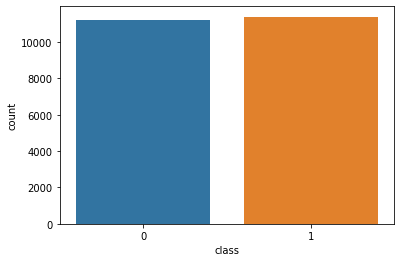

In [12]:
sns.countplot(Trainig['class'])


In [13]:
def preprocessing(data):
    for i in range(0,data.shape[0]):
        tokens = tokenization(data , i )
        data['#english_words'][i] = len(re.findall(r'[A-Za-z]+', data['text'][i]))
        data['#hyperlinks'][i] = len(re.findall(r'https?:\/\/.*[\r\n]*', data['text'][i]))
        data['#numbers'][i] = len(re.findall('\d+', data['text'][i]))
        data['#hashtags'][i] = len(re.findall(r"#[a-zA-Z0-9أ-ى]+", data['text'][i]))
        data['#mentioning'][i] = len(re.findall(r"@[a-zA-Z0-9]+", data['text'][i]))
        data['#emojis'][i]=emoji.emoji_count(data['text'][i])
        segmentation(data,i)
        pure_tokens = drop_stop_words(tokens)
    #     pure_tokens = stemming_Light(pure_tokens) #-> light_streamer , we don't use it . 
        pure_tokens = stemming(pure_tokens)
        data['puretext'][i] = ' '.join(pure_tokens)
        # print(tokens)
    return data

In [14]:
def puringtext(data):
    data['puretext'] = data['puretext'].apply(remove_newlines_tabs)
    data['puretext'] = data['puretext'].apply(remove_punctuations)
    data['puretext'] = data['puretext'].apply(removing_mentioning)
    data['puretext'] = data['puretext'].apply(removing_hashtags)
    data['puretext'] = data['puretext'].apply(remove_numbers)
    data['puretext'] = data['puretext'].apply(remove_links)
    data['puretext'] = data['puretext'].apply(remove_emojis)
    data['puretext'] = data['puretext'].apply(remove_english)
    data['puretext'] = data['puretext'].apply(remove_diacritics)

    return data['puretext']

In [15]:
Trainig=preprocessing(Trainig)
Trainig.drop('text',axis=1,inplace=True)


In [16]:
Trainig['puretext']=puringtext(Trainig)


In [17]:
Trainig.head()

,class,sentenses_len,puretext,#english_words,#hashtags,#mentioning,#hyperlinks,#numbers,#emojis
0,1,1,جمل يقظ صبح شكر ربك عرف فضل عليك بعث انس فؤل ...,0,1,0,0,0,1
1,0,2,حلى كده,0,0,0,0,0,1
2,0,1,طحلب صعب نقع,0,0,0,0,0,3
3,0,1,نظر لزل تمس فيك وغر اسف فيك قهر,0,0,0,0,0,1
4,0,1,انا كلم مو عشن شي عشن حلت نفس تعب,0,0,0,0,0,1


# Feature Extraction

In [18]:


def FeatureExtraction(Data):
    
#     # TF-IDF Feature Exetractor
    vec = TfidfVectorizer()
    features = vec.fit_transform(Data['puretext']).astype('float32')
    tf_idf =pd.DataFrame(features.toarray(), columns= vec.vocabulary_.keys())
    
    return tf_idf 


In [19]:
Traing_tf_idf=FeatureExtraction(Trainig)

In [20]:
Traing_tf_idf.shape

(22637, 16150)

In [21]:
concat=pd.concat([Trainig.iloc[:,[1,3,4,5,6,7,8]],Traing_tf_idf],axis=1)


In [22]:
X_train, X_test, y_train, y_test=train_test_split(concat,Trainig['class'],test_size=0.2)


# Modeling

In [23]:
linear_svc=LinearSVC(C=.02)
linear_svc.fit(X_train,y_train)


print('SVCModel Train Score is : ' , linear_svc.score(X_train, y_train))
print('SVCModel Test Score is : ' , linear_svc.score(X_test, y_test))


SVCModel Train Score is :  0.7656413937820973
SVCModel Test Score is :  0.7111307420494699


In [24]:
y_pred=linear_svc.predict(X_test)

acc1 = accuracy_score(y_test, y_pred)
f1_score1 = f1_score(y_test, y_pred, average='macro')

print(classification_report(y_test, y_pred))
print('Accuracy: {:0.3f}'.format(acc1))
print('F1-score: {:0.3f}'.format(f1_score1))

              precision    recall  f1-score   support

           0       0.68      0.78      0.73      2230
           1       0.75      0.64      0.69      2298

    accuracy                           0.71      4528
   macro avg       0.72      0.71      0.71      4528
weighted avg       0.72      0.71      0.71      4528

Accuracy: 0.711
F1-score: 0.710


# Deep Learning Model

In [37]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers.core import Flatten
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
dataWithoutFeatures=Trainig.puretext
labeling=Trainig['class']

In [27]:
max_sentence=0
for i in dataWithoutFeatures:
    tokens = nltk.word_tokenize(i)
    token_len=len(tokens)
    if (max_sentence<token_len):
        max_sentence=token_len

In [28]:
max_sentence

1015

In [29]:
vocab_size = 3000
max_sequence_len = 300

In [30]:
tokinizer=Tokenizer(num_words=vocab_size,split=' ')
tokinizer.fit_on_texts(list(dataWithoutFeatures))

In [31]:
Training_token = tokinizer.texts_to_sequences(dataWithoutFeatures)

In [32]:
# data padding
train_padded = pad_sequences(Training_token, maxlen=max_sequence_len)

In [33]:
X_train, X_test, y_train, y_test=train_test_split(train_padded,Trainig['class'],test_size=0.2)


In [38]:
print(X_train.shape)
print(y_train.shape)
print('='*50)
print(X_test.shape)
print(y_test.shape)

(18109, 300)
(18109,)
(4528, 300)
(4528,)


In [52]:
model=Sequential()
model.add(Embedding(vocab_size,128,input_length=X_train.shape[1]))
model.add(Bidirectional(LSTM(128)))
# model.add(Dense(128))
# model.add(Activation('relu'))
# model.add(Dense(64))
# model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(2))
model.add(Activation('sigmoid'))
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


# early stop function
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 128)          384000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_14 (Dense)             (None, 512)               131584    
_________________________________________________________________
activation_14 (Activation)   (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 1026      
_________________________________________________________________
activation_15 (Activation)   (None, 2)                 0         
Total params: 779,778
Trainable params: 779,778
Non-trainable params: 0
________________________________________________

In [53]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test),batch_size = 128,epochs=10, callbacks=[early_stop])

Epoch 1/10
142/142 [==============================] - 12s 61ms/step - loss: 0.5828 - accuracy: 0.6686 - val_loss: 0.5201 - val_accuracy: 0.7250
Epoch 2/10
142/142 [==============================] - 8s 57ms/step - loss: 0.4686 - accuracy: 0.7648 - val_loss: 0.5191 - val_accuracy: 0.7420
Epoch 3/10
142/142 [==============================] - 8s 57ms/step - loss: 0.4139 - accuracy: 0.8019 - val_loss: 0.5211 - val_accuracy: 0.7332
Epoch 4/10
142/142 [==============================] - 8s 57ms/step - loss: 0.5911 - accuracy: 0.7664 - val_loss: 0.5593 - val_accuracy: 0.7186
Epoch 5/10
142/142 [==============================] - 8s 57ms/step - loss: 0.4181 - accuracy: 0.7982 - val_loss: 0.5634 - val_accuracy: 0.7328
